In [132]:
# car_evalution 구성
# 1. price(자동차 가격)
# 2. maint(자동차 유지 비용)
# 3. doors(자동차 문 개수)
# 4. persons(수용 인원)
# 5. lug_capacity(수하물 용량)
# 6. safety(안정성)
# 7. output(차 상태) : 이 데이터는 unacc(허용 불가능한 수준) 및  acc(허용 가능한 수준), 
# 양호(good) 및 매우 좋은(very good, vgood) 중 하나의 값을 갖는다.

In [2]:
# 필요한 라이브러리 호출

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# 데이터 호출

dataset = pd.read_csv("../chap 02/data/car_evaluation.csv") # car_evaluation.csv 불러오기
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<AxesSubplot:ylabel='output'>

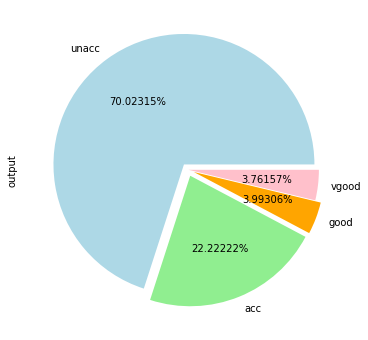

In [4]:
# 예제 데이터셋 분포

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%',
colors = ['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05, 0.005))

In [5]:
# 데이터를 범주형 타입으로 변환

categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety'] # 에제 데이터셋 칼럼들의 목록

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category') # astype() 메서드를 이용하여 데이터를 범주형(category)으로 변환

# 범주형 데이터를 텐서로 변환하기 위해 다음과 같은 절차가 필요하다.
# 범주형 데이터 -> dataset[category] -> 넘파이 배열(Numpy array) -> 텐서(Tensor)
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1) # 두개 이상의 넘파이 객체를 합칠 때 np.stack()을 사용한다.

In [6]:
# 배열을 텐서로 변환
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [7]:
# 레이블로 사용할 칼럼을 텐서로 변환

# get_dummies()는 가변수(dummy variable)로 만들어 주는 함수다.
# 가변수로 만들어 준다는 의미는 문자를 숫자 (0, 1)로 바꾸어 준다는 의미다.
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() # 1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [8]:
# 범주형 칼럼을 N차원으로 변환

categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [9]:
# 데이터셋 분리

total_records = 1728
test_records = int(total_records * .2) # 전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [10]:
# 데이터셋 분리 확인

print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [11]:
# 모델의 네트워크 생성

class Model(nn.Module): # 클래스 형태로 구현되는 모델은 nn.Module을 상속받는다
    def __init__(self, embedding_size, output_size, layers, p=0.4): # *1
        super().__init__() # 부모 클래스(Model 클래스)에 접근할 때 사용하며 self를 사용하지 않는 것에 주의해야 한다.
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols # 입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size 변수에 저장
        
        for i in layers: # 2*
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
        
        all_layers.append(nn.Linear(layers[-1], output_size))
        # 신경망의 모든 계층이 순차적으로 실행되도록 모든 계층에 대한 목록(all_layers)을 nn.Sequential 클래스로 전달
        self.layers = nn.Sequential(*all_layers)
    
    def forward(self, x_categorical): # *3
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) # 넘파이의 concatenate와 같지만 대상이 텐서가 된다.
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x
    
# *1 : def __init__(⑴self, ⑵embedding_size, ⑶output_size, ⑷layers, ⑸p=0.4)
# ⑴ self : 첫번째 파라미터는 self를 지정해야 자기 자신(객체)를 의미한다
# ⑵ embedding_size : 범주형 칼럼의 임베딩 크기
# ⑶ output_size : 출력층의 크기
# ⑷ layers : 모든 계층에 대한 목록
# ⑸ p=0.4 : 드롭아웃(기본값을 0.5)

# *2 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가한다.
# 추가한 계층은 다음과 같다.

# • Linear : 선형 계층(linear layer)은 입력 데이터에 선형 변환을 진행한 결과이다.
#            선형 변환을 위해서는 다음 수식을 사용한다.
#                    y = Wx + b
#            y : 선형 계층의 출력 값, W : 가중치, x : 입력 값, b : 바이어스
#            따라서 선형 계층은 입력과 가중치를 곱한 후 바이어스를 더한 결과다.
# • ReLu : 활성화 함수로 사용
# • BatchNorm1d : 배치 정규화(batch normalization) 용도로 사용
# • Dropout : 과적합 방지에 사용(좋은데?)

# *3 forward() : 함수는 학습 데이터를 입력받아서 연산을 진행한다.
#                forward()느 함수는 모델 객체를 데이터와 함께 호출하면 자동으로 실행된다.

In [12]:
# Model 클래스의 객체 생성

model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [13]:
# 모델의 파라미터 정의

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# CPU/GPU 사용 지정

if torch.cuda.is_available():
    device = torch.device('cuda') # GPU 인식이 된다면 GPU 사용
else :
    device = torch.device('cpu') # GPU 인식이 안 된다면 CPU 사용

print(device)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(device=device))

cuda
True
NVIDIA GeForce RTX 2060


In [15]:
# 모델 학습

epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs): # for 문은 500회 반복되며, 각 반복마다 손실 함수가 오차를 계산
    i += 1
    y_pred = model(categorical_train_data) # forward 작동
    y_pred = y_pred.to(device=device, dtype=torch.float32) # *교과서에는 이 부분이 없어서 오류가 뜨던데?
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 aggregated_loss에 추가
    
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        
    optimizer.zero_grad()
    single_loss.backward() # 가중치 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}') # 25 에폭마다 오차 출력

epoch:   1 loss: 1.53874004
epoch:  26 loss: 1.31971014
epoch:  51 loss: 1.23067832
epoch:  76 loss: 1.14664638
epoch: 101 loss: 1.02664518
epoch: 126 loss: 0.92336595
epoch: 151 loss: 0.81480139
epoch: 176 loss: 0.72474629
epoch: 201 loss: 0.68085980
epoch: 226 loss: 0.66985768
epoch: 251 loss: 0.64561468
epoch: 276 loss: 0.62077469
epoch: 301 loss: 0.61014462
epoch: 326 loss: 0.60220724
epoch: 351 loss: 0.59436291
epoch: 376 loss: 0.59302312
epoch: 401 loss: 0.57941294
epoch: 426 loss: 0.57877111
epoch: 451 loss: 0.58188504
epoch: 476 loss: 0.57091421
epoch: 500 loss: 0.5755871534


In [38]:
# 테스트 데이터셋으로 모델 예측

test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    y_val = y_val.to(device=device, dtype=y_val.dtype)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.57437104


In [39]:
# 모델의 예측 확인

print(y_val[:5])

tensor([[ 3.2152,  1.9140, -3.2914, -3.2332],
        [ 2.8264,  1.6578, -3.5259, -3.4361],
        [ 2.6832,  1.8267, -5.3868, -5.4448],
        [ 2.4676,  1.4109, -3.0324, -2.9049],
        [ 2.0439,  1.1083, -2.4474, -2.4586]], device='cuda:0')


In [40]:
# 가장 큰 값을 갖는 인덱스 확인

y_val = y_val.to(device=torch.device('cpu'), dtype=y_val.dtype)
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [41]:
# 테스트 데이터셋을 이용한 정확도 확인

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_outputs = test_outputs.to(device=torch.device('cpu'), dtype=test_outputs.dtype)
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[259   0]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.00      0.00      0.00        86

    accuracy                           0.75       345
   macro avg       0.38      0.50      0.43       345
weighted avg       0.56      0.75      0.64       345

0.7507246376811594


c:\Users\choiw\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\choiw\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\choiw\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
